# **Data scraping of spotify artists data**

Function showing size of network at each iteration of expansion of artist's related artists.

## Scraping loop

In [34]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tqdm as tqdm
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np


load_dotenv('.env.example')

api_key = os.getenv("SPOTIFY_API_KEY")
client_id = os.getenv("SPOTIFY_CLIENT_ID")
redirect_uri = "https://github.com/Jacopo00811/socialgraphs2025-project"

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=api_key)
sp = spotipy.Spotify(auth_manager=auth_manager)

### Getting featured artists

We must have `include_groups = 'ablum, single'` to avoid getting artist's "appears on" ablums - which are not really collaborations.

In [157]:
def get_featured_artists(artist_id):
    feature_artists = []
    feature_artist_ids = []

    albums = sp.artist_albums(artist_id, include_groups='album,single')

    for album in albums["items"]:
        tracks = sp.album_tracks(album["id"])["items"] 
        for track in tracks:
            feature_artist = [a["name"] for a in track["artists"] if a['id'] != artist_id]
            feature_artists.extend(feature_artist)

        feature_artist_id = [a["id"] for a in track["artists"] if a['id'] != artist_id]
        feature_artist_ids.extend(feature_artist_id)
    
    feature_artists = list(set(feature_artists))
    feature_artist_ids = list(set(feature_artist_ids))

    return feature_artists, feature_artist_ids

In [158]:
playlist_id = "57EG9lWmdn7HHofXuQVsow"
results = sp.playlist_items(playlist_id)
artist_names = []

count = 0
for item in results["items"]:
    track = item["track"]
    artist_names.append(track['artists'][0]['name'])
    print(f"{track['artists'][0]['name']}")
    count += 1
    

print("\nTotal number of printed tracks:", count)

sombr
HUNTR/X
Alex Warren
Lady Gaga
Ravyn Lenae
Jin
TWOPILOTS
Rihanna
KATSEYE
sombr
PinkPantheress
Taylor Swift
Olivia Dean
The Goo Goo Dolls
Disco Lines
DE SOFFER
WizTheMc
Moonshine
Choujaa
Gracie Abrams
Taylor Swift
Olivia Dean
Billie Eilish
ROSÉ
RAZZ
MOLIY
Connie Francis
James Hersey
50 Cent
Kendrick Lamar
oskar med k
Samuel Miller
Cup of Joe
Imogen Heap
Kendrick Lamar
Tkandz
Chappell Roan
Sabrina Carpenter
Zac Tenenbaum
Lady Gaga
sped up kid
Chappell Roan
RAYE
bbno$
Tate McRae
Braaheim
Drake
The Marías
TWOPILOTS
Tate McRae
Sabrina Carpenter
Brian Michael Hinds
Hozier
Sabrina Carpenter
ZEROBASEONE
Adam Port
Braaheim
CYRIL
Crystal Rock
Artemas
Braaheim
Black Eyed Peas
ATLXS
Jaxomy
CIBUS
Braaheim
Gigi Perez
Luson
Fourtwnty
Sevdaliza
W Sound
Ariana Grande
Journey
Sabrina Carpenter
Natty Rico
Travis Scott
yung kai
Kripa
Shaboozey
Tom Penny
Arctic Monkeys
Alyssa Palmer
Lola Young
cassö
De Hofnar
BL3SS
Kav Verhouzer
Disturbed
Braaten
Doechii
Kenya Grace
Teddy Swims
Gunna
Charli xcx
Braahe

In [215]:
graph = {artist_name: [] for artist_name in artist_names}

def feature_scraper(graph, frontier):

    if not frontier:
        frontier = []

        for artist_name in tqdm.tqdm(graph.keys()):
            results = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)
            artist = results["artists"]["items"][0]
            artist_id = artist["id"]

            featured_artists, featured_artist_ids = get_featured_artists(artist_id)
            graph[artist_name] = featured_artists

            if featured_artists:
                frontier.append(featured_artists)
    
    else:
        for artist_name in tqdm.tqdm(frontier):
            results = sp.search(q=f"artist:{artist_name}", type="artist", limit=1)
            artist = results["artists"]["items"][0]
            artist_id = artist["id"]

            featured_artists, featured_artist_ids = get_featured_artists(artist_id)
            graph[artist_name] = featured_artists
    

        
    return graph, set(frontier)

In [ ]:
graph, frontier  = feature_scraper(graph, None)
graph, frontier  = feature_scraper(graph, frontier)

 15%|█▌        | 13/85 [00:35<03:43,  3.10s/it]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 78887


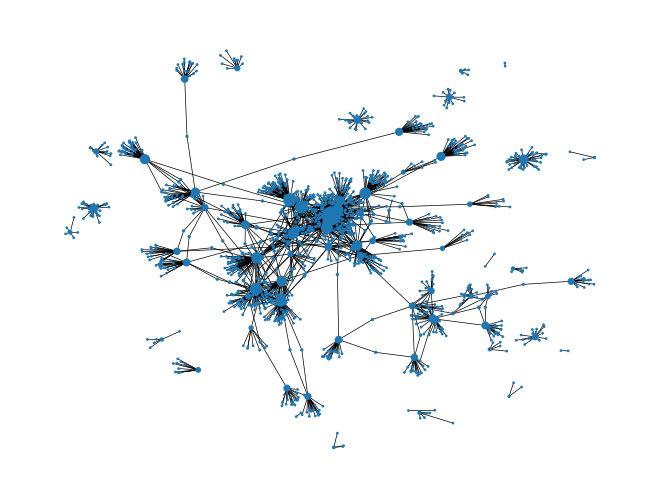

In [196]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(graph)

G_degrees = [G.degree(node) for node in G.nodes()]  
nx.draw(G, with_labels=False, width=0.5, node_size=[d*1 for d in G_degrees])
plt.show()

In [213]:
top_100_neighbors = []
max_neighbors = 0
for artist_name in artist_names:
    num_neighbors = len(list(G.neighbors(artist_name)))
    top_100_neighbors.append(num_neighbors)
    if num_neighbors > max_neighbors:
        max_neighbors = num_neighbors
        most_connected_artist = artist_name

most_connected_artist, max_neighbors

('David Guetta', 162)

[]

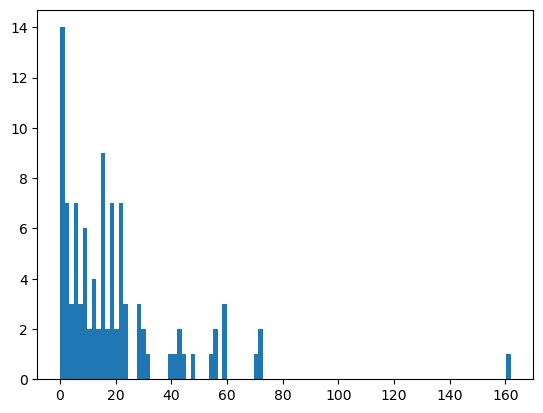

In [211]:
plt.hist(top_100_neighbors, bins=len(top_100_neighbors))
plt.plot()

# **Lyrics extractor**

This is a function built to extract lyrics from the "Genius" website. Inputs are the song title and artist names both as string, and the output is the lyrics as a string.

REQUIREMENTS:

You must go to the [Genius API website](https://genius.com/api-clients) and create a "New API Client". Once you have that, you just generate an acess token to paste into the variable in the code cell below.

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

GENIUS_TOKEN = os.getenv("GENIUS_TOKEN")

In [41]:
def get_lyrics(song_title, artist_name):
    base_url = "https://api.genius.com/search"
    headers = {"Authorization": f"Bearer {GENIUS_TOKEN}"}
    params = {"q": f"{song_title} {artist_name}"}
    response = requests.get(base_url, headers=headers, params=params).json()

    hits = response["response"]["hits"]
    if not hits:
        print("No results found.")
        return None

    # Pick first correct artist result
    for hit in hits:
        result = hit["result"]
        if result["primary_artist"]["name"].lower() == artist_name.lower():
            song_url = result["url"]
            break
    else:
        song_url = hits[0]["result"]["url"]

    # Scrape the lyrics page
    page = requests.get(song_url)
    soup = BeautifulSoup(page.text, "html.parser")

    # Extract lyrics
    lyrics_divs = soup.select("div[data-lyrics-container='true']")
    if lyrics_divs:
        lyrics = "\n".join(div.get_text(separator="\n") for div in lyrics_divs)
    else:
        candidates = soup.find_all("div", class_=re.compile("(Lyrics__Root|Lyrics-sc-|SongPage__Section)"))
        lyrics = "\n".join(c.get_text(separator="\n") for c in candidates) if candidates else ""

    # Trim off everything above the first [Verse 1]
    match = re.search(r"\[verse\s*1\]", lyrics, flags=re.IGNORECASE)
    if match:
        lyrics = lyrics[match.start():]   # keep from [Verse 1] onward
    
    # Remove everything in brackets (like [Chorus], [Bridge] and such)
    lyrics = re.sub(r"\[.*?\]", "", lyrics)

    # Optional: stop at footer sections
    lyrics = re.split(r"You might also like|Embed|See.*Lyrics$", lyrics)[0].strip()

    return lyrics if lyrics else None

Testing below.

In [ ]:
print(get_lyrics("", "Chappell Roan"))

It's fine, it's cool
You can say that we are nothing, but you know the truth
And guess I'm the fool
With her arms out like an angel through the car sunroof

I don't wanna call it off
But you don't wanna call it love
You only wanna be the one that I call "baby"

You can kiss a hundred boys in bars
Shoot another shot, try to stop the feeling
You can say it's just the way you are
Make a new excuse, 'nother stupid reason
Good luck, babe (Well, good luck)
Well, good luck, babe (Well, good luck)
You'd have to stop the world just to stop the feeling
Good luck, babe (Well, good luck)
Well, good luck, babe (Well, good luck)
You'd have to stop the world just to stop the feeling

I'm cliché, who cares?
It's a sexually explicit kind of love affair
And I cry, it's not fair
I just need a little lovin', I just need a little air


Think I'm gonna call it off
Even if you call it love
I just wanna love someone who calls me "baby"

You can kiss a hundred boys in bars
Shoot another shot, try to stop the f